Dhiraj Kumar - https://dhirajkumarblog.medium.com/

Credit Risk Prediction in Retail Lending: A Comparative Study Using SHAP

In [1]:
!pip install shap lightgbm xgboost scikit-learn pandas matplotlib seaborn -q


In [2]:
# ✅ Import libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

import shap
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

shap.initjs()
import warnings
warnings.filterwarnings("ignore")



In [3]:
# Load German Credit data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric'
#url = "https://raw.githubusercontent.com/ChicagoBoothML/MLClassData/master/GiveMeSomeCredit/CreditScoring.csv"
df = pd.read_csv(url, delim_whitespace=True, header=None)
df.columns = [f'feature_{i}' for i in range(1, 25)] + ['target']
df['target'] = df['target'].replace({1: 0, 2: 1})  # Good credit = 0, Bad credit = 1

X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(df.shape)

(1000, 25)


In [4]:
# Evaluation helper
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {acc:.3f}, AUC: {auc:.3f}, F1-score: {f1:.3f}")
    return model


In [5]:
# SHAP safe waterfall plot
def safe_shap_waterfall_plot(explainer, shap_values, X_test, prefix):
    try:
        if isinstance(explainer.expected_value, (list, np.ndarray)):
            expected_val = explainer.expected_value[1] if len(explainer.expected_value) > 1 else explainer.expected_value[0]
        else:
            expected_val = explainer.expected_value

        if isinstance(shap_values, list):
            shap_val = shap_values[1][0] if len(shap_values) > 1 else shap_values[0][0]
        else:
            shap_val = shap_values[0]

        shap.plots._waterfall.waterfall_legacy(expected_val, shap_val, X_test.iloc[0])
        plt.savefig(f"{prefix}_waterfall.png", bbox_inches='tight')
        print(f" Waterfall plot saved as {prefix}_waterfall.png")

    except Exception as e:
        print(f" SHAP waterfall plot error: {e}")




Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       141
           1       0.67      0.49      0.57        59

    accuracy                           0.78       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.77      0.78      0.77       200

Accuracy: 0.780, AUC: 0.696, F1-score: 0.569
SHAP shape: (200, 24)
X_test shape: (200, 24)


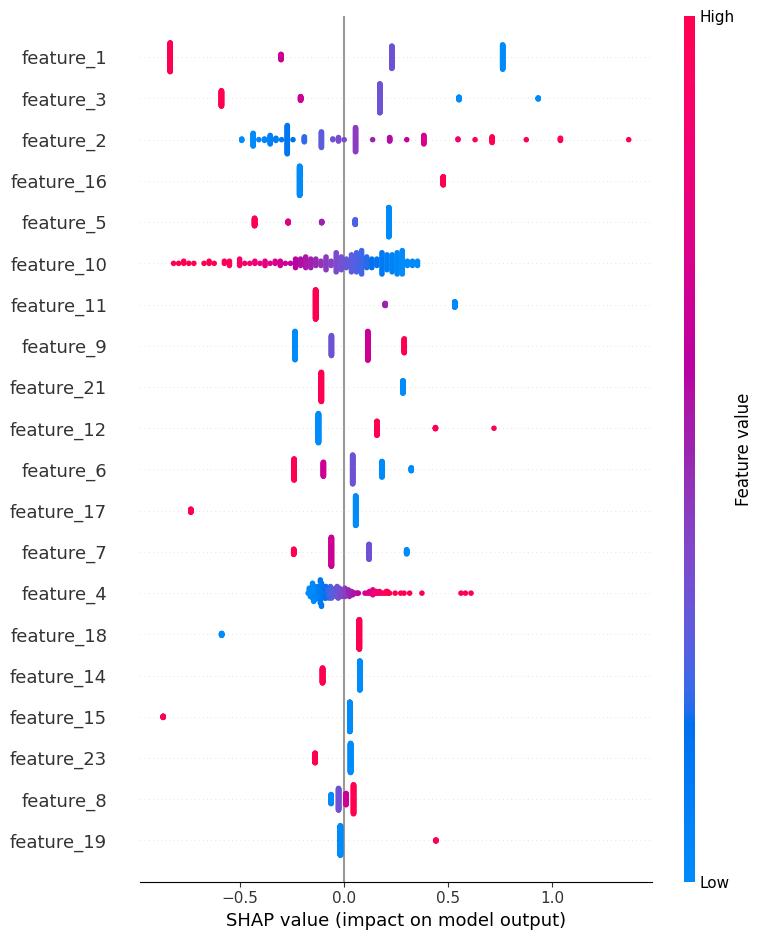

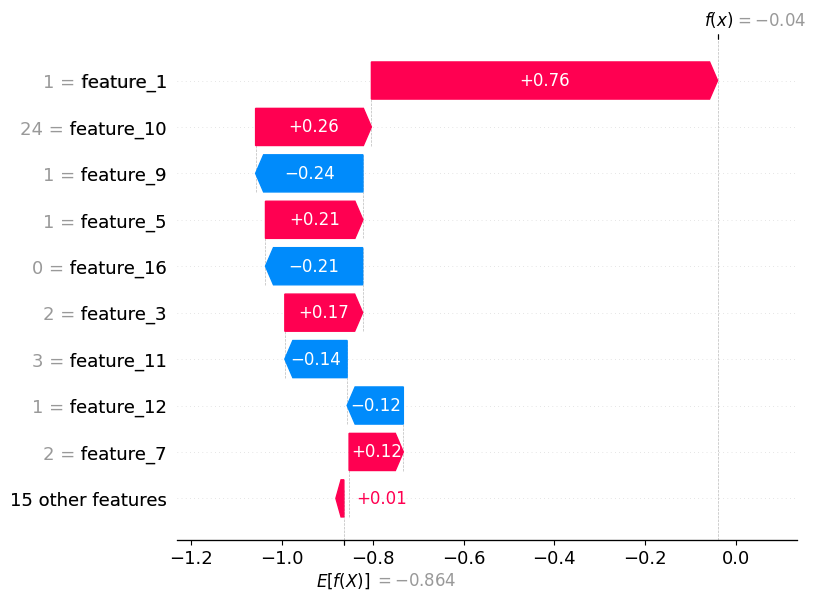

In [6]:
# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_model = evaluate_model(lr, "Logistic Regression")

# Create a SHAP explainer with model + background data
explainer_lr = shap.Explainer(lr_model, X_train)

# Compute SHAP values
shap_values = explainer_lr(X_test)  # <--- returns shap.Explanation object

# Check shape
print("SHAP shape:", shap_values.values.shape)  # (200, 24)
print("X_test shape:", X_test.shape)

# SHAP summary plot
shap.summary_plot(shap_values.values, X_test, show=False)
plt.savefig("lr_summary.png", bbox_inches='tight')
plt.show()

# Waterfall plot
shap.plots.waterfall(shap_values[0], show=False)
plt.savefig("lr_waterfall.png", bbox_inches='tight')
plt.show()


[LightGBM] [Info] Number of positive: 241, number of negative: 559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301250 -> initscore=-0.841353
[LightGBM] [Info] Start training from score -0.841353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

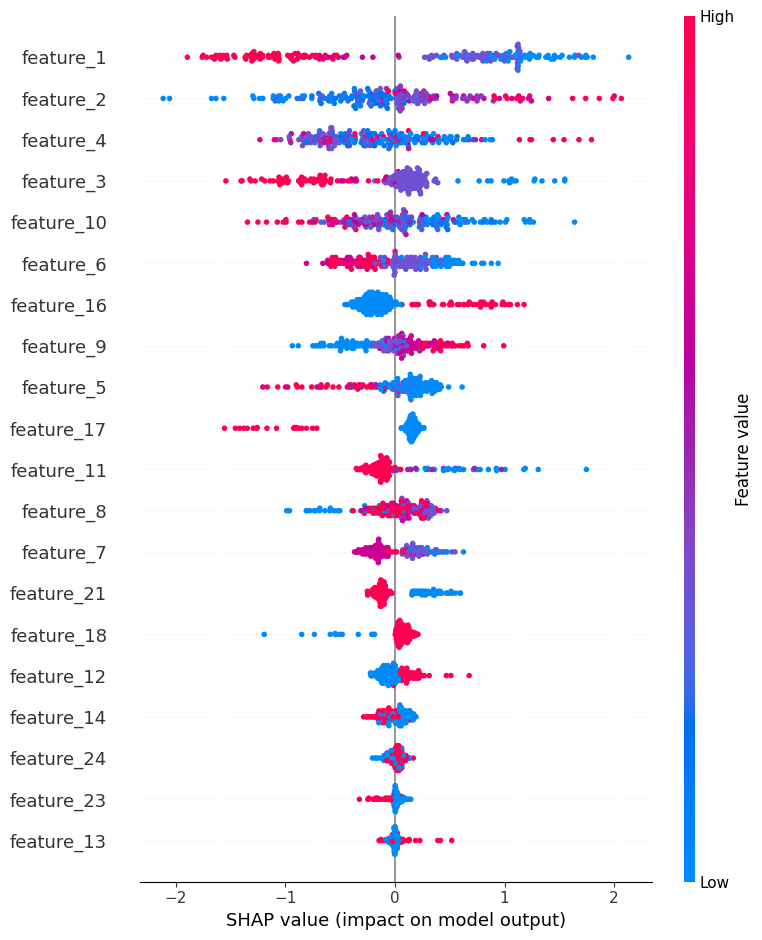

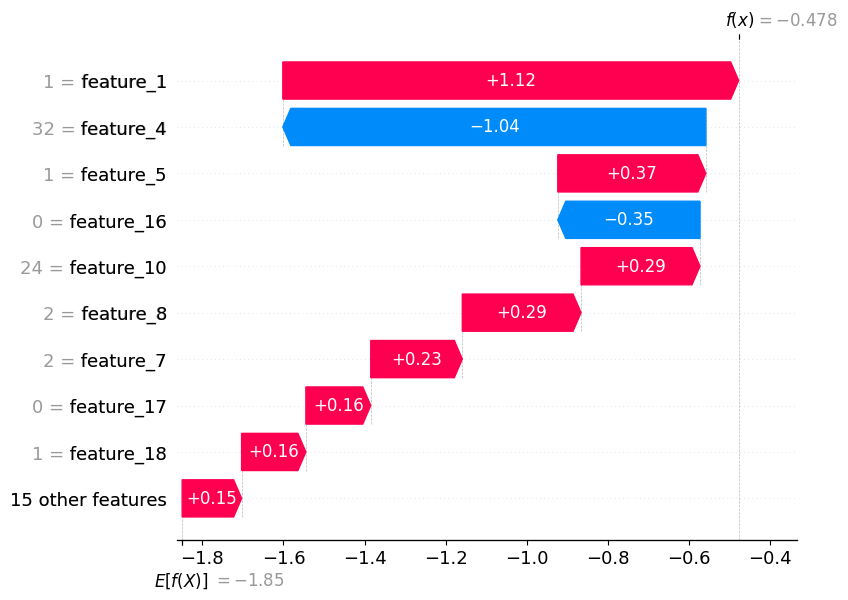

In [7]:
# Step 1: Train LightGBM model
lgb_model = LGBMClassifier(random_state=42)
lgb_model = evaluate_model(lgb_model, "LightGBM")

# Step 2: Tree SHAP explainer
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Step 3: Normalize output based on whether shap_values is a list or array
if isinstance(shap_values_lgb, list):
    shap_vals_lgb = shap_values_lgb[1]  # Use class 1 for binary
    expected_val_lgb = explainer_lgb.expected_value[1]
else:
    shap_vals_lgb = shap_values_lgb  # Already a 2D matrix
    expected_val_lgb = explainer_lgb.expected_value

# Step 4: Check shape before plotting
print(" SHAP shape:", shap_vals_lgb.shape)
print(" X_test shape:", X_test.shape)
assert shap_vals_lgb.shape == X_test.shape, " SHAP and X_test shapes don't match!"

# Step 5: SHAP Summary Plot
shap.summary_plot(shap_vals_lgb, X_test, show=False)
plt.savefig("lgb_summary.png", bbox_inches='tight')
plt.show()

# Step 6: SHAP Waterfall Plot (for first prediction)
shap_expl_lgb = shap.Explanation(
    values=shap_vals_lgb[0],
    base_values=expected_val_lgb,
    data=X_test.iloc[0],
    feature_names=X_test.columns
)

shap.plots.waterfall(shap_expl_lgb, show=False)
plt.savefig("lgb_waterfall.png", bbox_inches='tight')
plt.show()



XGBoost
              precision    recall  f1-score   support

           0       0.83      0.91      0.86       141
           1       0.71      0.54      0.62        59

    accuracy                           0.80       200
   macro avg       0.77      0.73      0.74       200
weighted avg       0.79      0.80      0.79       200

Accuracy: 0.800, AUC: 0.725, F1-score: 0.615
XGB SHAP shape: (200, 24)
X_test shape: (200, 24)


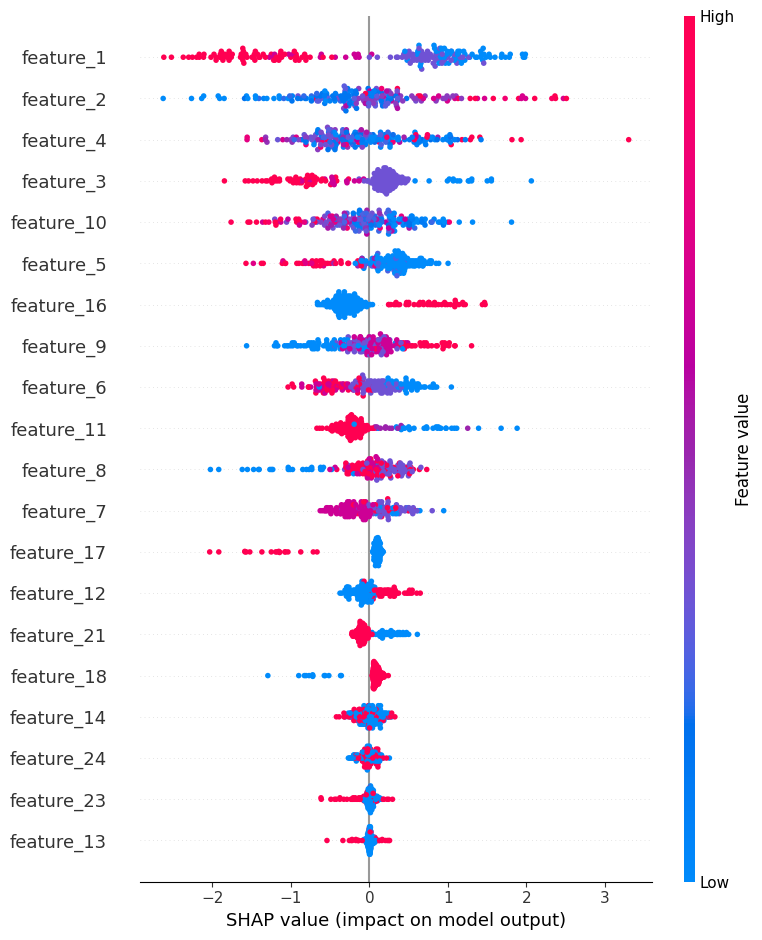

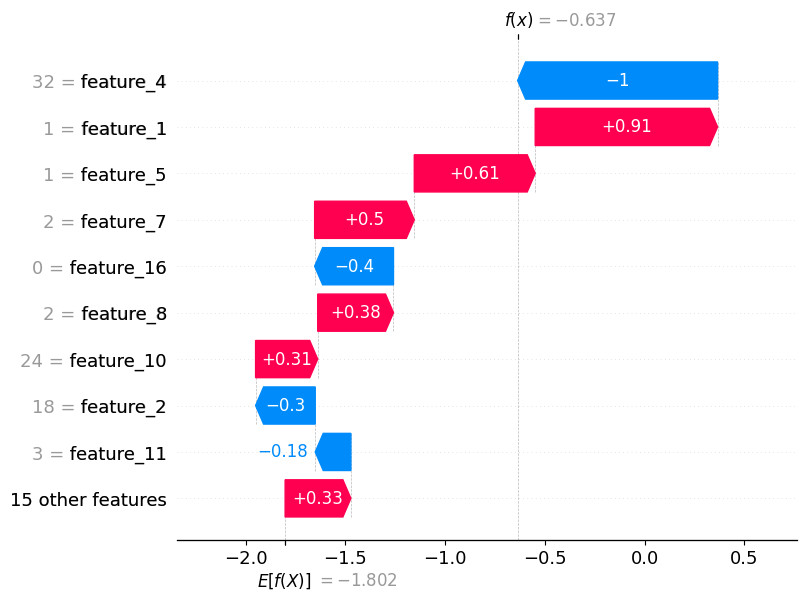

In [8]:

from xgboost import XGBClassifier

# Train model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model = evaluate_model(xgb, "XGBoost")

# SHAP Explainer
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

# Check shape
print("XGB SHAP shape:", shap_values_xgb.values.shape)
print("X_test shape:", X_test.shape)

# SHAP summary plot
shap.summary_plot(shap_values_xgb.values, X_test, show=False)
plt.savefig("xgb_summary.png", bbox_inches='tight')
plt.show()

# SHAP waterfall plot (first prediction)
shap.plots.waterfall(shap_values_xgb[0], show=False)
plt.savefig("xgb_waterfall.png", bbox_inches='tight')
plt.show()


In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n🧠 {name} Performance Report:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{cm}")

    return {
        'Model': name,
        'Accuracy': round(acc, 3),
        'AUC': round(auc, 3),
        'F1-score': round(f1, 3),
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'Confusion Matrix': cm
    }


In [10]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Run evaluations
results = []
results.append(evaluate_model(LogisticRegression(max_iter=1000), "Logistic Regression"))
results.append(evaluate_model(LGBMClassifier(random_state=42), "LightGBM"))
results.append(evaluate_model(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), "XGBoost"))



🧠 Logistic Regression Performance Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       141
           1       0.67      0.49      0.57        59

    accuracy                           0.78       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.77      0.78      0.77       200

Confusion Matrix:
[[127  14]
 [ 30  29]]
[LightGBM] [Info] Number of positive: 241, number of negative: 559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301250 -> initscore=-0.841353
[LightGBM] [Info] Start training from score -0.841353
[LightGBM] [Warning] No further splits

In [11]:
import pandas as pd

# Convert to DataFrame excluding confusion matrix column for table display
results_df = pd.DataFrame([{k: v for k, v in row.items() if k != 'Confusion Matrix'} for row in results])

print("\n Model Performance Comparison:")
print(results_df)

# Optional: Save
results_df.to_csv("model_comparison_metrics.csv", index=False)



 Model Performance Comparison:
                 Model  Accuracy    AUC  F1-score  Precision  Recall
0  Logistic Regression      0.78  0.696     0.569      0.674   0.492
1             LightGBM      0.79  0.713     0.596      0.689   0.525
2              XGBoost      0.80  0.725     0.615      0.711   0.542


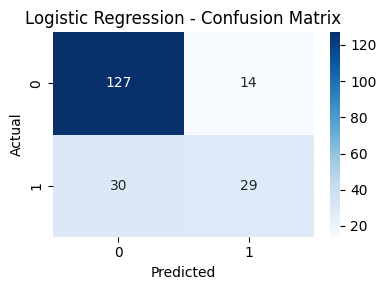

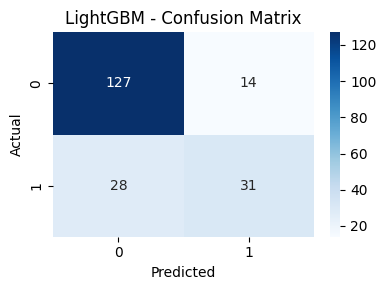

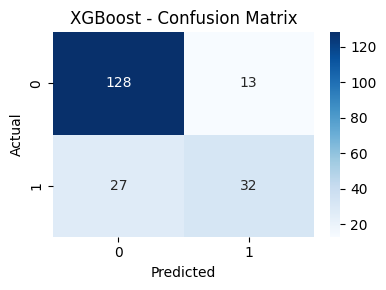

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

for row in results:
    plt.figure(figsize=(4, 3))
    sns.heatmap(row['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"{row['Model']} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
